### If you're using your own machine, install qiskit first
To do that, uncomment the line below and run cell

In [1]:
# !pip install qiskit
# To update qiskit:
# !pip install -U qiskit

### And check version — should match the one below

In [2]:
import qiskit
qiskit.__qiskit_version__

/Users/ruslan/soft/anaconda3/envs/qiskit_latest/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


{'qiskit-terra': '0.18.1', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.16.0', 'qiskit-aqua': '0.9.4', 'qiskit': '0.29.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.2.0', 'qiskit-machine-learning': '0.2.1'}

### Let's solve MAXCUT on a simple graph

Recall the MAXCUT objective is $\max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(1-s_is_j)$

Before going further, let's reformulate it:

$\frac{1}{2}\sum_{ij\in E}(1-s_is_j) = \frac{1}{2}\sum_{ij\in E}(-s_is_j) + const$

Therefore the above _maximization_ problem is equivalent to the problem below:

$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$

### Constructing the Hamiltonian

MAXCUT is equivalent to the problem below:

$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$

We've seen earlier that the Hamiltonian can be constructed by mapping binary variables $s_i$ onto the eigenvalues of $Z$. For the above maximization problem has the following Hamiltonian:

$\sum_{ij\in E}(-Z_iZ_j)$

### Constructing QAOA circuit

Cost Hamiltonian: $C = \sum_{ij\in E}(-Z_iZ_j)$

The full QAOA circuit:

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

Need to implement cost operator $e^{-i\gamma_p C}$ and mixer operator $e^{-i\beta_p B}$

### Let's beging by importing everything we'll need later

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

### Consider the following graph

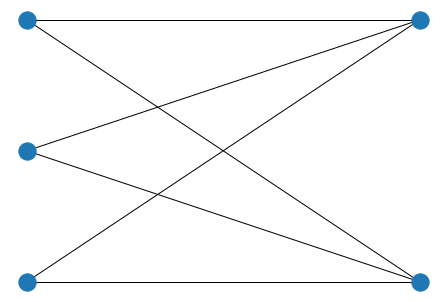

In [4]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))

### We can now build the circuit for cost operator

Cost operator $ e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)}$

Note that later we will see how to do this more efficiently in Qiskit

In [5]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
    

### Let's verify that our function produces the correct circuit

Cost operator $e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)}$

In [6]:
qc = get_cost_operator_circuit(G, np.pi / 3)
qc.draw()

»
q_0: ──■────────────────■────■────────────────────────────■─────────────────»
       │                │    │     ┌───┐    ┌──────────┐  │  ┌───┐     ┌───┐»
q_1: ──┼────────────────┼────┼─────┤ X ├────┤ Rz(2π/3) ├──┼──┤ X ├─────┤ X ├»
       │                │    │     └─┬─┘    └──────────┘  │  └─┬─┘┌───┐└─┬─┘»
q_2: ──┼────────────────┼────┼───────┼────────────────────┼────┼──┤ X ├──┼──»
     ┌─┴─┐┌──────────┐┌─┴─┐  │       │                    │    │  └─┬─┘  │  »
q_3: ┤ X ├┤ Rz(2π/3) ├┤ X ├──┼───────■────────────────────┼────■────■────┼──»
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐            ┌─┴─┐            │  »
q_4: ──────────────────────┤ X ├┤ Rz(2π/3) ├────────────┤ X ├────────────■──»
                           └───┘└──────────┘            └───┘               »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                 
«q_0: ────────────────────────────────────────────
«     ┌──────────┐     ┌───┐                      
«q_1: ┤ Rz(2π/3) ├─────┤ X ├──────────────────────
«     ├──────────┤┌───┐└─┬─┘┌───┐┌──────────┐┌───┐
«q_2: ┤ Rz(2π/3) ├┤ X ├──┼──┤ X ├┤ Rz(2π/3) ├┤ X ├
«     └──────────┘└─┬─┘  │  └─┬─┘└──────────┘└─┬─┘
«q_3: ──────────────■────┼────┼────────────────┼──
«                        │    │                │  
«q_4: ───────────────────■────■────────────────■──
«                                                 
«c: 5/════════════════════════════════════════════
«

### Now we need to build mixer operator

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}$

In [7]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc


### Let's verify the circuit

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}e^{-i\beta_p X_4}$

In [8]:
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     └──────────┘
c: 5/════════════

### Now we are ready to build the full circuit

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

In [9]:
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

### Let's verify that circuit looks right

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

In [10]:
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

<ipython-input-9-7a860757a1f1>:10: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
/Users/ruslan/soft/anaconda3/envs/qiskit_latest/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


┌───┐                                               ┌──────────┐          »
q_0: ┤ H ├──■─────────────■────■──────────────────────■──┤ Rx(2π/3) ├──────────»
     ├───┤  │             │    │    ┌───┐  ┌───────┐  │  └──┬───┬───┘     ┌───┐»
q_1: ┤ H ├──┼─────────────┼────┼────┤ X ├──┤ Rz(π) ├──┼─────┤ X ├─────────┤ X ├»
     ├───┤  │             │    │    └─┬─┘  └───────┘  │     └─┬─┘    ┌───┐└─┬─┘»
q_2: ┤ H ├──┼─────────────┼────┼──────┼───────────────┼───────┼──────┤ X ├──┼──»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │      │               │       │      └─┬─┘  │  »
q_3: ┤ H ├┤ X ├┤ Rz(π) ├┤ X ├──┼──────■───────────────┼───────■────────■────┼──»
     ├───┤└───┘└───────┘└───┘┌─┴─┐┌───────┐         ┌─┴─┐                   │  »
q_4: ┤ H ├───────────────────┤ X ├┤ Rz(π) ├─────────┤ X ├───────────────────■──»
     └───┘                   └───┘└───────┘         └───┘                      »
c: 5/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                  ░ ┌─┐      »
«q_0: ─────────────────────────────────────────────────────────────░─┤M├──────»
«     ┌───────┐     ┌───┐┌──────────┐                              ░ └╥┘┌─┐   »
«q_1: ┤ Rz(π) ├─────┤ X ├┤ Rx(2π/3) ├──────────────────────────────░──╫─┤M├───»
«     ├───────┤┌───┐└─┬─┘└──┬───┬───┘ ┌───────┐  ┌───┐┌──────────┐ ░  ║ └╥┘┌─┐»
«q_2: ┤ Rz(π) ├┤ X ├──┼─────┤ X ├─────┤ Rz(π) ├──┤ X ├┤ Rx(2π/3) ├─░──╫──╫─┤M├»
«     └───────┘└─┬─┘  │     └─┬─┘    ┌┴───────┴─┐└─┬─┘└──────────┘ ░  ║  ║ └╥┘»
«q_3: ───────────■────┼───────┼──────┤ Rx(2π/3) ├──┼───────────────░──╫──╫──╫─»
«                     │       │      └──────────┘  │  ┌──────────┐ ░  ║  ║  ║ »
«q_4: ────────────────■───────■────────────────────■──┤ Rx(2π/3) ├─░──╫──╫──╫─»
«                                                     └──────────┘ ░  ║  ║  ║ »
«c: 5/════════════════════════════════════════════════════════════════╩══╩══╩═»
«                                                                     0  1  2 »
«           
«q_0: ──────
«           
«q_1: ──────
«           
«q_2: ──────
«     ┌─┐   
«q_3: ┤M├───
«     └╥┘┌─┐
«q_4: ─╫─┤M├
«      ║ └╥┘
«c: 5/═╩══╩═
«      3  4

### Running a circuit in Qiskit

For the purposes of this tutorial, we will be running the circuits in simulator. To run your circuits on real IBM quantum computers, all you need to do is change the backend. However, the devices are noisy, so there might be dragons!

#### Qiskit qubit ordering

Note that Qiskit uses an ordering where zeroth qubit is the rightmost (the least significant bit in the bistring),
so we need to invert the samples we received

In [11]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

Now we can run the circuit

In [12]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'11011': 27, '01001': 34, '00110': 43, '00001': 33, '10011': 35, '00100': 31, '00011': 43, '01000': 23, '11001': 27, '01110': 29, '00000': 36, '01100': 38, '10111': 28, '10010': 33, '10101': 24, '10100': 33, '11100': 39, '00101': 42, '11110': 33, '11101': 27, '10110': 25, '00010': 32, '10001': 32, '11010': 32, '10000': 27, '01011': 29, '11111': 35, '01101': 35, '01111': 33, '00111': 35, '01010': 33, '11000': 18}


### How good were these results?

To answer that, we need to compute $<\psi|C|\psi>$. Luckily, C is a classical Hamiltonian, so we can do this easily. We are going to compute -1 times the value of the cut because by convention classical optimizers minimize (this will come up shortly).

In [13]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('00011', G)

-6

### Estimate energy from the sample

In [14]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-3.05078125

### Putting all the pieces together

As you remember, we run QAOA as a variational algorithm, so we will need a classical optimizer to optimize the parameters $\beta$, $\gamma$. We will use Constrained Optimization BY Linear Approximation (COBYLA) from `scipy.optimize`.

We need to wrap our circuit into a black-box objective function `f` that COBYLA could optimize. Note that by convention all optimizers perform _minimization_, so we had to put a minus sign in front of our objective earlier.

In [15]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

### Now we can run the optimizer to get optimal parameters!

In [16]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

     fun: -5.2978515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 134
  status: 1
 success: True
       x: array([1.83749394, 2.1345936 , 1.9319531 , 2.09862998, 0.347631  ,
       2.04618358, 6.11249139, 2.31785137, 3.56479392, 5.87260613])

### To get the solution strings, let's run the circuit with optimal parameters

In [17]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts

{'01000': 1,
 '01010': 1,
 '11001': 1,
 '01110': 1,
 '10010': 1,
 '11011': 6,
 '11100': 370,
 '00101': 5,
 '10101': 2,
 '10100': 22,
 '11110': 36,
 '11101': 31,
 '10110': 1,
 '00100': 2,
 '00110': 4,
 '00111': 19,
 '00010': 23,
 '10000': 1,
 '01011': 25,
 '01111': 2,
 '11000': 14,
 '00011': 379,
 '01100': 19,
 '10111': 3,
 '00001': 27,
 '10011': 25,
 '01101': 3}

### How good are there results?

<BarContainer object of 4 artists>

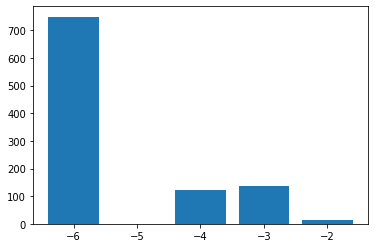

In [18]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

Pretty good! Most of the results we get correspond to good solutions!

Best string: 11100 with cut: 6


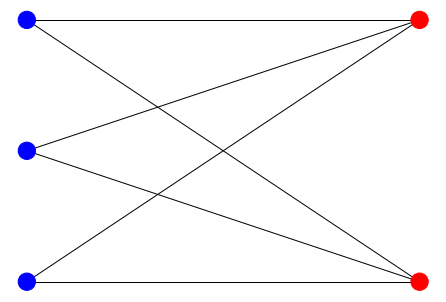

In [19]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

### Using statevector simulator

What if you want to get the full QAOA state? Luckily, Qiskit provides `statevector_simulator` backend. 

### What is a state vector?

State vector is a vector of amplitudes, e.g.: $\frac{1}{\sqrt{2}}\bigg(|00\rangle + |11\rangle\bigg) \rightarrow (\frac{1}{\sqrt{2}}, 0, 0, \frac{1}{\sqrt{2}})$

In [20]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
sv = execute(qc, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
sv

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

Less luckily, qubit ordering considerations still apply. Below are some helper functions we're going to use.

In [21]:
# Endianness conversion tools from https://github.com/Qiskit/qiskit-terra/issues/1148#issuecomment-438574708

import numpy as np

def state_num2str(basis_state_as_num, nqubits):
    return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

def state_str2num(basis_state_as_str):
    return int(basis_state_as_str, 2)

def state_reverse(basis_state_as_num, nqubits):
    basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
    new_str = basis_state_as_str[::-1]
    return state_str2num(new_str)

def get_adjusted_state(state):
    nqubits = np.log2(state.shape[0])
    if nqubits % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    nqubits = int(nqubits)

    adjusted_state = np.zeros(2**nqubits, dtype=complex)
    for basis_state in range(2**nqubits):
         adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
    return adjusted_state

### Running using full-state (`statevector`) simulator

Note that a few things are different when using the full statevector simulator. First, we must not measure. Second, as the result, we get amplitudes instead of samples.

In [22]:
def get_qaoa_circuit_sv(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # no measurement in the end!
    return qc

Second, we need to get which amplitudes correspond to which computational basis states (= binary strings)

In [23]:
def state_to_ampl_counts(vec, eps=1e-15):
    """Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts


Let's try plugging in the optimal parameters we found using the QASM simulator

In [24]:
backend = Aer.get_backend('statevector_simulator')
qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
sv = get_adjusted_state(execute(qc, backend).result().get_statevector())
state_to_ampl_counts(sv)

{'00000': (0.014279499254842742+0.011623320789211036j),
 '00001': (0.13438201589051332-0.09405829764019878j),
 '00010': (0.13438201589051343-0.0940582976401987j),
 '00011': (-0.01602140096028865-0.6036236563655756j),
 '00100': (-0.053501339525443524+0.006060075992361446j),
 '00101': (-0.03628471735810238-0.010367992306133616j),
 '00110': (-0.0362847173581025-0.010367992306133658j),
 '00111': (-0.06213658117215947+0.13217051841932284j),
 '01000': (-0.05350133952544355+0.006060075992361485j),
 '01001': (-0.036284717358102424-0.010367992306133627j),
 '01010': (-0.036284717358102396-0.010367992306133554j),
 '01011': (-0.062136581172159436+0.1321705184193229j),
 '01100': (-0.06213658117215936+0.13217051841932298j),
 '01101': (-0.036284717358102445-0.010367992306133628j),
 '01110': (-0.03628471735810239-0.010367992306133656j),
 '01111': (-0.05350133952544348+0.006060075992361326j),
 '10000': (-0.053501339525443496+0.00606007599236145j),
 '10001': (-0.036284717358102375-0.010367992306133703j)

### Let's verify that we get the same energy

In [25]:
def compute_maxcut_energy_sv(sv, G):
    """Compute objective from statevector
    For large number of qubits, this is slow. 
    """
    counts = state_to_ampl_counts(sv)
    return sum(maxcut_obj(np.array([int(x) for x in k]), G) * (np.abs(v)**2) for k, v in counts.items())

compute_maxcut_energy_sv(sv, G)

-5.2962604856081175

Yay! Energy matches

### Now, we can run the full optimization loop with the statevector simulator

In [26]:
def get_black_box_objective_sv(G,p):
    backend = Aer.get_backend('statevector_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit_sv(G,beta, gamma)
        sv = execute(qc, backend).result().get_statevector()
        # return the energy
        return compute_maxcut_energy_sv(get_adjusted_state(sv), G)
    return f

Copying and pasting the code for the `qasm_simulator`...

In [27]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective_sv(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sv = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sv

     fun: -5.953065284815716
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2500
  status: 2
 success: False
       x: array([2.23608646, 1.98401476, 1.98178779, 1.81071698, 0.5632291 ,
       2.25515488, 6.06921404, 2.40791231, 3.78127733, 6.03418269])

We get **much better solution** if we have access to the full state vector! In fact, if we run it long enough, we will get arbitratily close to the true optimum (to verify it yourself, try setting `'maxiter':10000` above)

In [28]:
print(f"Best energy with samples: {res_sample['fun']:.4f}, with full state vector: {res_sv['fun']:.4f}")

Best energy with samples: -5.2979, with full state vector: -5.9531


This is because with samples we get stuck in a lower quality point:

In [29]:
print(f"Angles found with samples: beta={res_sample['x'][:p]}, gamma={res_sample['x'][p:]}")
print(f"Angles found with full state: beta={res_sv['x'][:p]}, gamma={res_sv['x'][p:]}")

Angles found with samples: beta=[1.83749394 2.1345936  1.9319531  2.09862998 0.347631  ], gamma=[2.04618358 6.11249139 2.31785137 3.56479392 5.87260613]
Angles found with full state: beta=[2.23608646 1.98401476 1.98178779 1.81071698 0.5632291 ], gamma=[2.25515488 6.06921404 2.40791231 3.78127733 6.03418269]


Note that these are two different points!

An important point to make is that this is **not a local minimum** that COBYLA gets stuck in when using the sampling. We can easily verify that by running COBYLA with full state from that point

In [30]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective_sv(G, p)

init_point = res_sample['x']
# 'rhobeg' controls initial changes to the variables. 
# We set it low to make sure we are searching a small neighborhood of the optimal point
res_sv2 = minimize(obj, init_point, method='COBYLA', options={'maxiter':50, 'disp': True, 'rhobeg': 0.001})
res_sv2

     fun: -5.379488009621092
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 50
  status: 2
 success: False
       x: array([1.84912811, 2.1430627 , 1.94267686, 2.08362536, 0.36741251,
       2.04556667, 6.12254338, 2.30958241, 3.57688979, 5.86524965])

The lesson here is that our simple deterministic optimizers (like COBYLA) assume that *every function value they get is true*. This causes them to thing that a point is a local minimum, when in fact it is not. We have to bake the assumption of stochaisticity into the optimizers we use!

### That was pretty involved! Is there an easier way?

So far we have effectively reimplemented the entire stack of tools used in Qiskit. Wasn't too bad, huh? Note that you can fairly easily do the above in any framework you prefer (Google cirq, Rigetti PyQuil, ...), all you need to learn is how to apply gates. What follows is more specific to IBM Qiskit (though not entirely).

Luckily, you don't have to reimplement QAOA every time you want to use it (though I do recommend doing it at least once to understand what's going on!)

Qiskit provides a number of tools for optimization, some as simple to use as plugging your graph into a declarative interface. Today we're going to look at some of them. I have copied and pasted some of the code from Qiskit here for educational purposes.

### Recap

To solve MAXCUT we had to do the following:

1. Choose a problem class (maxcut) and a problem instance (graph)
2. Come up with a general Hamiltonian for the problem class
3. Build specific Hamiltonian for the problem instance
4. From the Hamiltonian, construct QAOA circuit
5. Wrap QAOA circuit in a black box function
6. Optimize QAOA parameters
7. Get solution by running QAOA circuit with optimal parameters

### Qiskit to help!

Let's see how Qiskit can help us with steps 3 and 4:


1. Choose a problem class (maxcut) and a problem instance (graph)
2. Come up with a general Hamiltonian for the problem class
3. **Build specific Hamiltonian for the problem instance**
4. **From the Hamiltonian, construct QAOA circuit**
5. Wrap QAOA circuit in a black box function
6. Optimize QAOA parameters
7. Get solution by running QAOA circuit with optimal parameters

### Building the Hamiltonian in Qiskit

To build the Hamiltonian in Qiskit, we need to construct the optimization problem in appropriate format (e.g. load from Docplex)

In [31]:
# copied from https://github.com/QAOAKit/QAOAKit/blob/722304af4a09f8dfc2753726f3c7b1577154ccd1/QAOAKit/qaoa.py#L60

from qiskit_optimization import QuadraticProgram

def get_cost_operator(G):
    """Generate Hamiltonian for the max-cut problem of a graph
    """
    n_qubits = len(G.nodes())
    problem = QuadraticProgram()
    _ = [problem.binary_var("x{}".format(i)) for i in range(n_qubits)]
    problem.maximize(
        linear=nx.adjacency_matrix(G).dot(np.ones(n_qubits)),
        quadratic=-nx.adjacency_matrix(G),
    )
    return problem.to_ising()

### First, let's construct a Hamiltonian 

Recall the MAXCUT objective is $\max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(1-s_is_j) = \max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(-s_is_j) + const$. Qiskit conveniently takes care of the constant in form of offset.

Corresponding Hamiltonian is $\frac{1}{2}\sum_{ij\in E}(-Z_iZ_j)$, but Qiskit by convention always searches for the _ground_ state, so the sign is flipped.

In [32]:
C, offset = get_cost_operator(G)
print(C)

0.5 * ZIZII
+ 0.5 * IZZII
+ 0.5 * ZIIZI
+ 0.5 * IZIZI
+ 0.5 * IIZIZ
+ 0.5 * IIIZZ


Looks correct!

We can generate the QAOA circuit for this Hamiltonian:

In [33]:
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOAAnsatz

p = 1 

ansatz = QAOAAnsatz(C, p).decompose()

ansatz.draw()

┌───┐┌───┐┌──────────────┐┌───┐┌───┐┌──────────────┐                ┌───┐»
q_0: ┤ H ├┤ X ├┤ Rz(1.0*t[0]) ├┤ X ├┤ X ├┤ Rz(1.0*t[0]) ├────────────────┤ X ├»
     ├───┤└─┬─┘└──────────────┘└─┬─┘└─┬─┘└────┬───┬─────┘┌──────────────┐└─┬─┘»
q_1: ┤ H ├──■────────────────────■────┼───────┤ X ├──────┤ Rz(1.0*t[0]) ├──┼──»
     ├───┤                            │       └─┬─┘      └──────────────┘  │  »
q_2: ┤ H ├────────────────────────────■─────────┼──────────────────────────■──»
     ├───┤                                      │                             »
q_3: ┤ H ├──────────────────────────────────────■─────────────────────────────»
     ├───┤                                                                    »
q_4: ┤ H ├────────────────────────────────────────────────────────────────────»
     └───┘                                                                    »
«     ┌──────────────┐                                                         »
«q_0: ┤ Rx(2.0*t[1]) ├─────────────────────────────────────────────────────────»
«     └────┬───┬─────┘     ┌───┐┌──────────────┐     ┌───┐┌──────────────┐     »
«q_1: ─────┤ X ├───────────┤ X ├┤ Rz(1.0*t[0]) ├─────┤ X ├┤ Rx(2.0*t[1]) ├─────»
«          └─┬─┘      ┌───┐└─┬─┘├──────────────┤┌───┐└─┬─┘└──────────────┘┌───┐»
«q_2: ───────┼────────┤ X ├──┼──┤ Rz(1.0*t[0]) ├┤ X ├──┼──────────────────┤ X ├»
«            │        └─┬─┘  │  └──────────────┘└─┬─┘  │  ┌──────────────┐└─┬─┘»
«q_3: ───────■──────────■────┼────────────────────■────┼──┤ Rx(2.0*t[1]) ├──┼──»
«                            │                         │  └──────────────┘  │  »
«q_4: ───────────────────────■─────────────────────────■────────────────────■──»
«                                                                              »
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ─────────────────────────────────────
«     ┌──────────────┐┌───┐┌──────────────┐
«q_2: ┤ Rz(1.0*t[0]) ├┤ X ├┤ Rx(2.0*t[1]) ├
«     └──────────────┘└─┬─┘└──────────────┘
«q_3: ──────────────────┼──────────────────
«                       │  ┌──────────────┐
«q_4: ──────────────────■──┤ Rx(2.0*t[1]) ├
«                          └──────────────┘

And plug in the parameters

In [34]:
angles = np.random.uniform(low=0, high=np.pi / 2, size=2 * p)
qc = ansatz.bind_parameters(angles)
qc.draw()

┌───┐┌───┐┌───────────────────────┐┌───┐┌───┐┌───────────────────────┐»
q_0: ┤ H ├┤ X ├┤ Rz(0.176359853333493) ├┤ X ├┤ X ├┤ Rz(0.176359853333493) ├»
     ├───┤└─┬─┘└───────────────────────┘└─┬─┘└─┬─┘└─────────┬───┬─────────┘»
q_1: ┤ H ├──■─────────────────────────────■────┼────────────┤ X ├──────────»
     ├───┤                                     │            └─┬─┘          »
q_2: ┤ H ├─────────────────────────────────────■──────────────┼────────────»
     ├───┤                                                    │            »
q_3: ┤ H ├────────────────────────────────────────────────────■────────────»
     ├───┤                                                                 »
q_4: ┤ H ├─────────────────────────────────────────────────────────────────»
     └───┘                                                                 »
«                              ┌───┐┌──────────────────────┐          »
«q_0: ─────────────────────────┤ X ├┤ Rx(2.43110758250072) ├──────────»
«     ┌───────────────────────┐└─┬─┘└────────┬───┬─────────┘     ┌───┐»
«q_1: ┤ Rz(0.176359853333493) ├──┼───────────┤ X ├───────────────┤ X ├»
«     └───────────────────────┘  │           └─┬─┘          ┌───┐└─┬─┘»
«q_2: ───────────────────────────■─────────────┼────────────┤ X ├──┼──»
«                                              │            └─┬─┘  │  »
«q_3: ─────────────────────────────────────────■──────────────■────┼──»
«                                                                  │  »
«q_4: ─────────────────────────────────────────────────────────────■──»
«                                                                     »
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«     ┌───────────────────────┐     ┌───┐┌──────────────────────┐     »
«q_1: ┤ Rz(0.176359853333493) ├─────┤ X ├┤ Rx(2.43110758250072) ├─────»
«     ├───────────────────────┤┌───┐└─┬─┘└──────────────────────┘┌───┐»
«q_2: ┤ Rz(0.176359853333493) ├┤ X ├──┼──────────────────────────┤ X ├»
«     └───────────────────────┘└─┬─┘  │  ┌──────────────────────┐└─┬─┘»
«q_3: ───────────────────────────■────┼──┤ Rx(2.43110758250072) ├──┼──»
«                                     │  └──────────────────────┘  │  »
«q_4: ────────────────────────────────■────────────────────────────■──»
«                                                                     »
«                                                           
«q_0: ──────────────────────────────────────────────────────
«                                                           
«q_1: ──────────────────────────────────────────────────────
«     ┌───────────────────────┐┌───┐┌──────────────────────┐
«q_2: ┤ Rz(0.176359853333493) ├┤ X ├┤ Rx(2.43110758250072) ├
«     └───────────────────────┘└─┬─┘└──────────────────────┘
«q_3: ───────────────────────────┼──────────────────────────
«                                │  ┌──────────────────────┐
«q_4: ───────────────────────────■──┤ Rx(2.43110758250072) ├
«                                   └──────────────────────┘